# Compromiso Sesgo-Variabilidad

En la clase anterior vimos que entrenar un solo árbol puede sobreajustar al problema que estamos tratando de resolver. Eso es porque los árboles de decisión son ***modelos flexibles***. Los modelos flexibles son capaces de aprender muy bien de los datos observados pero tienden a tener una variabilidad muy alta. 

Cuando decimos esto nos referimos a que en los modelos flexibles la distribución de probabilidad predicha es muy cercana a la distribución de probabilidad real, cuando ocurre esto se dice que el modelo tiene un ***sesgo*** bajo. 

Por otro lado estos modelos pueden cambiar de manera extrema cuando se alteran menormente las observaciones usadas para el entrenamiento. Esto hace que los modelos tengan alta ***variabilidad***

En machine learning es importante mantener un ***sesgo bajo*** o buen ajuste, manteniendo baja ***variabiliad***. A esto se le llama ***compromiso entre sesgo-variabilidad***-- en ingles es bias-variance trade-off

Metodos que agregan las predicciones de varios modelos pueden ayudar con este problema. En particular promediar o agregar las predicciones de varios árboles de decisión ayudar a disminuir la variabilidad en los modelos entrenados, manteniendo el sesgo relativamente bajo. 

# Random Forests

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

Los árboles de decisión fueron desarrollados en Berkley por Leo Breiman, uno de los creadores de los árboles de clasificación y regresión (CART), pero lo hizo en un proceso que duró desde 1984 cuando el monográfo de CART fue publicado y 2001 cuando L. Breiman publicó sus descrubrimientos entrenando RFs. 

Hay dos cosas a saber sobre los árboles de decisión: 
1. Los árboles son creados sobre subconjuntos de las observaciones elegidos al azar. 
2. Las variables usadas para hacer las decisiones en los nodos son elegidas al azar, nunca usando todas las variables para tomar las decisiones. 

El primer punto nos dice que las observaciones son muestradas al azar con reemplazo y pueden ser usadas variables veces en el mismo dataset de entrenamiento, ese proceso se llama bootstrapping. Sirve para aumentar la muestra de entrenamiendo de manera sintetica. 

Los resultados de los árboles entrenados con estos 'boostrapped' datasets son agregados. Por eso el metodo se llama bootstrap agreggating o bagging. 

El número de features usado en cada division de los árboles es la raíz cuadrada del total de variables disponibles. 

In [69]:
import numpy as np
import pandas as pd
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

seed = 500

In [5]:
df = pd.read_csv('C://Users//HP PC//Documents//20190722-ESEN/2015.csv').sample(100000, random_state = seed)
df.head()

_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
135068    20.0     5.0  b'06032015'  b'06'  b'03'  b'2015'    1100.0   
363436    48.0    11.0  b'11302015'  b'11'  b'30'  b'2015'    1200.0   
281879    36.0     9.0  b'09192015'  b'09'  b'19'  b'2015'    1100.0   
319088    41.0     4.0  b'04092015'  b'04'  b'09'  b'2015'    1100.0   
257664    34.0     1.0  b'02242015'  b'02'  b'24'  b'2015'    1100.0   

               SEQNO          _PSU  CTELENUM  ...  _PAREC1  _PASTAE1  \
135068  2.015019e+09  2.015019e+09       NaN  ...      4.0       2.0   
363436  2.015004e+09  2.015004e+09       1.0  ...      9.0       9.0   
281879  2.015007e+09  2.015007e+09       1.0  ...      1.0       1.0   
319088  2.015002e+09  2.015002e+09       1.0  ...      4.0       2.0   
257664  2.015001e+09  2.015001e+09       1.0  ...      3.0       2.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
135068       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
363436       9.0       9.0       9.0       9.0       9.0       NaN       NaN   
281879       3.0       3.0       4.0       1.0       1.0       2.0       2.0   
319088       2.0       2.0       3.0       1.0       1.0       NaN       NaN   
257664       1.0       1.0       1.0       1.0       1.0       NaN       NaN   

        _AIDTST3  
135068       2.0  
363436       NaN  
281879       1.0  
319088       2.0  
257664       2.0  

[5 rows x 330 columns]

In [6]:
df = df.select_dtypes('number')

Podemos ver que el data set no está balanceado. Por eso usar accuracy como métrica para cuantificar el error de generalización no es lo más adecuado. Usaremos el ROC.

In [7]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

1.0    81023
0.0    18702
Name: label, dtype: int64

In [10]:
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])


In [11]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = seed)

In [13]:
train = X_train.fillna(X_train.mean())
test = X_test.fillna(X_test.mean())



# Vamos a usar la lista de columnas para calcular la importancia de cada variable
features = list(train.columns)

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Creamos y entrenamos un árbol de decisión
tree = DecisionTreeClassifier(random_state=seed)

tree.fit(train, y_train)
print(f'El árbol de decision tiene {tree.tree_.node_count} nodos con una profundidad máxima de {tree.tree_.max_depth}.')

El árbol de decision tiene 12709 nodos con una profundidad máxima de 57.


In [22]:
print(f'Model Accuracy: {tree.score(test, y_test)}')

Model Accuracy: 0.7962430643759609


In [23]:
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [24]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.678235578857588


# OVERFITTING!!

In [29]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    test_labels=y_test
    train_labels=y_train
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.87 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.68 Train: 1.0


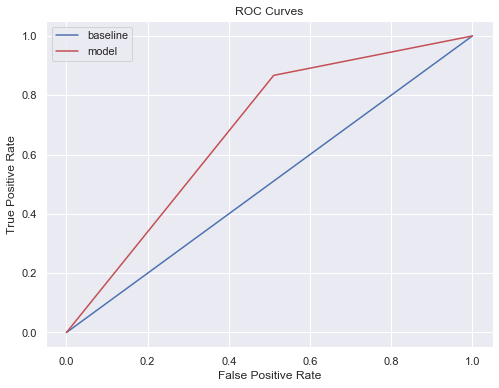

In [34]:
sns.set()
evaluate_model(predictions, probs, train_predictions, train_probs)

In [36]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [45]:
cm = confusion_matrix(y_test, predictions)
print(cm)


[[ 2746  2865]
 [ 3231 21076]]


Confusion matrix, without normalization
[[ 2746  2865]
 [ 3231 21076]]


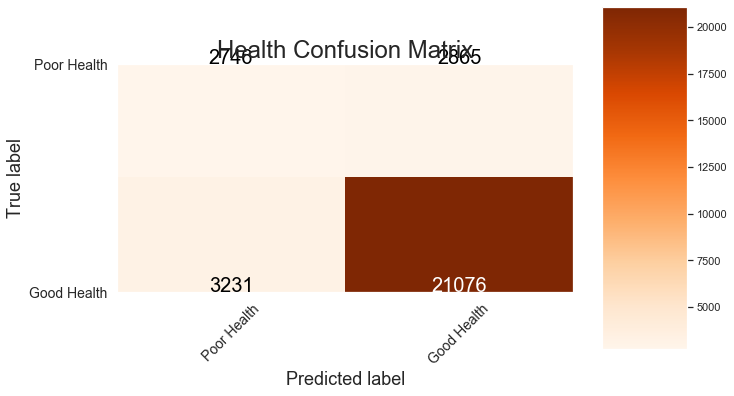

In [43]:
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'], title = 'Health Confusion Matrix')

In [50]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

tree = DecisionTreeClassifier(random_state=seed)
export_graphviz(tree.fit(train, y_train), 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

# Visualize
Image(filename='tree_real_data.png')

## Entrenando un Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=seed, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=500, verbose=1,
                       warm_start=False)

In [54]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13522
Average maximum depth 45


In [55]:
train_probs = model.predict_proba(train)[:, 1]
probs = model.predict_proba(test)[:, 1]

train_predictions = model.predict(train)
predictions = model.predict(test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.88 Train: 1.0


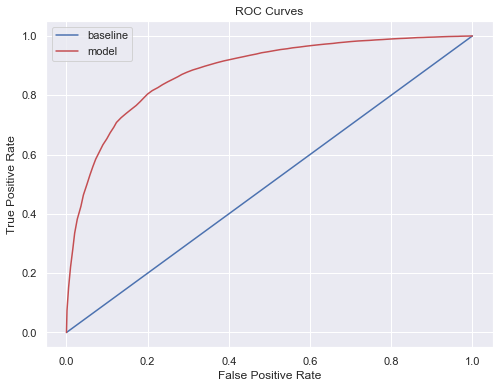

In [56]:
evaluate_model(predictions, probs, train_predictions, train_probs)

## Seleccion de Modelos
Vamos a Seleccionar el modelo con los mejores parametros.

In [61]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seed)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seed)

# Fit 
rs.fit(train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [62]:
best_model = rs.best_estimator_


train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [63]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 91
Average maximum depth 10


Recall Baseline: 1.0 Test: 0.97 Train: 0.97
Precision Baseline: 0.81 Test: 0.87 Train: 0.86
Roc Baseline: 0.5 Test: 0.88 Train: 0.88


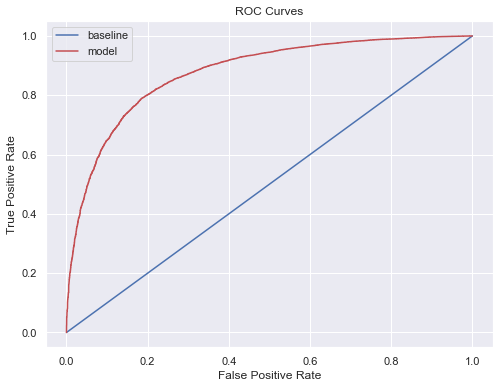

In [64]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [65]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

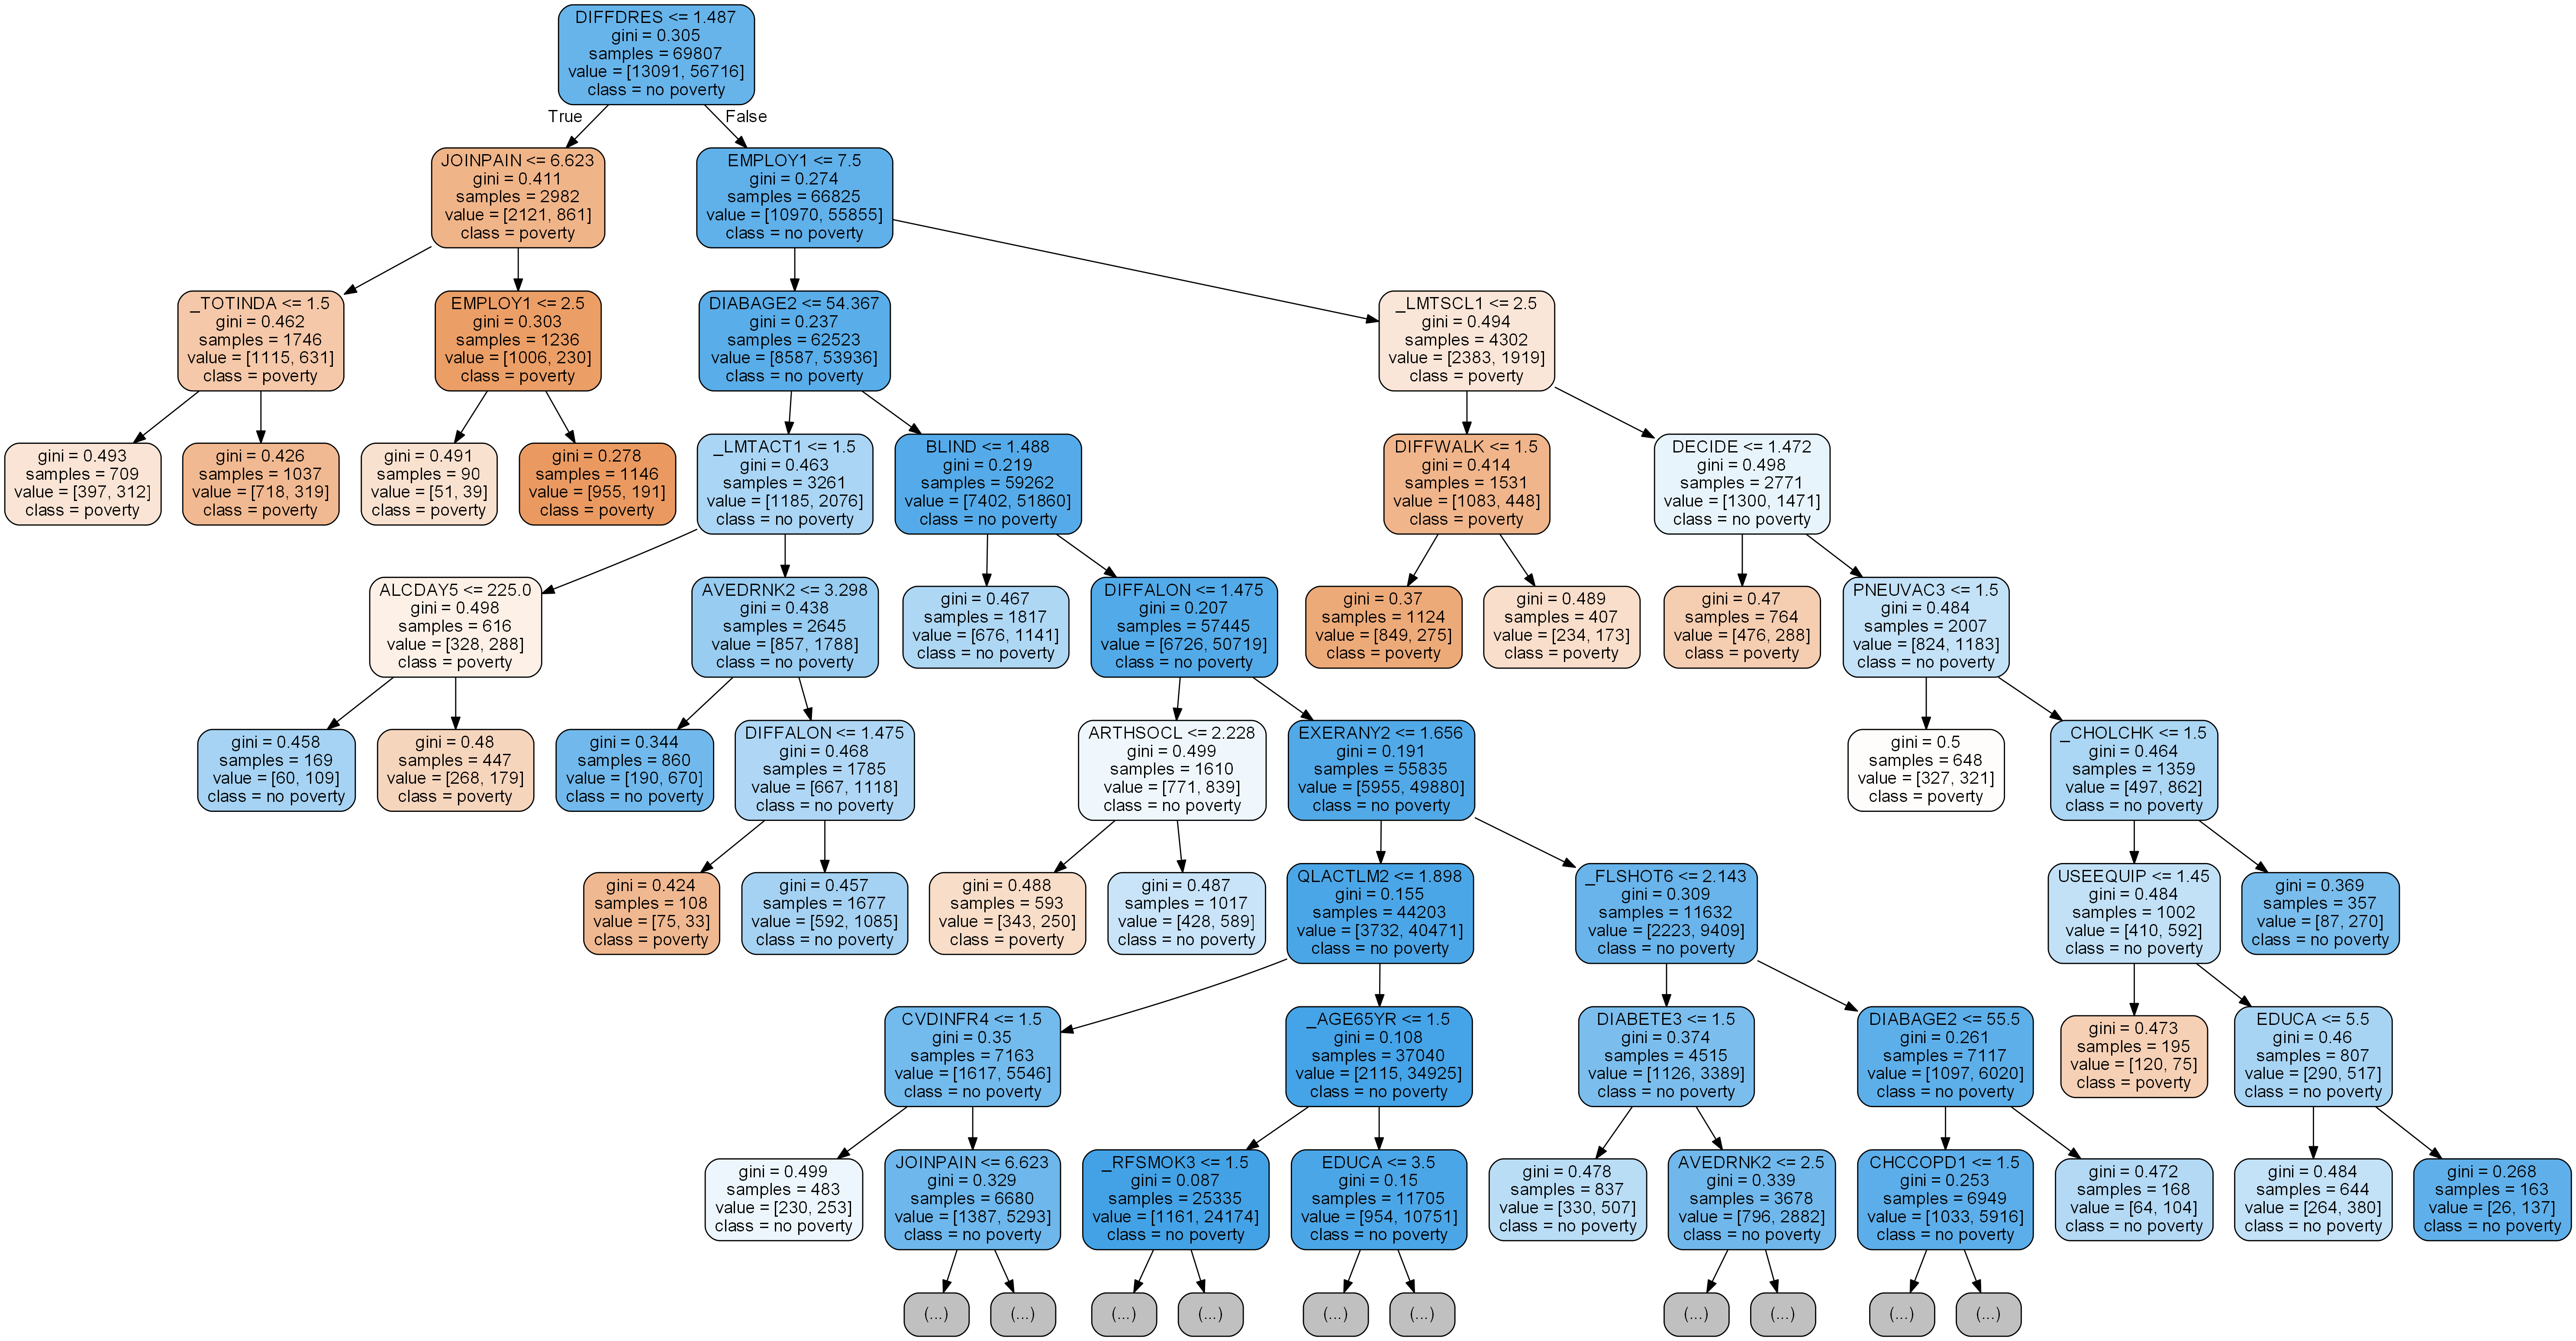

In [66]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

# Boosting

Tutorial:

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

Eso es todo lo que vamos a ver de árboles de decisión conmigo. Próxima semana intro a Redes Neuronales y a Deep Learning!!